In [1]:
#!/usr/bin/env python3

import os
import platform
import re
import gc
import warnings
import itertools
import datetime
import pandas as pd
import numpy as np
import ast
import joblib
from sklearn import linear_model
from sklearn import decomposition
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning

class SheepData():
    def __init__(self, read_alphas=False):
        """
        This class learns the coefficients for the phenotypic values measured during fattening and after slaughtering of sheep.
        Since the class has been shared extensively between different systems, it has adaptions to run under other system
        environments than the original development system. 
        """
        if "Linux" in platform.system():
            from Pedigree import Pedigree
            # Even though this approach has been largely dismissed as risking a slow
            # execution of functions, it seems to be the safest bet to avoid mistakes 
            # dealing with setups different than the ones tested extensively. Therefore, 
            # all modules, which have been written outside of pip are excluded for non-tested
            # platforms. A replacement has been supplied in the the data_cleaning()
            # function.
            #https://stackoverflow.com/questions/128478/should-import-statements-always-be-at-the-top-of-a-module/128577#128577
            if "/home/users" in os.environ["HOME"]:
                self.sheep_folder = f"{os.environ['HOME']}/Doktorarbeit/Daten/Schafe"
            else:
                self.sheep_folder = f"{os.environ['HOME']}/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/Daten/Schafe"
        if "Windows" in platform.system():
            self.sheep_folder = f"{os.environ['USERPROFILE']}/Documents/EIPProjekt/Schafdaten"
        self.xlsx_files = [v for v in os.listdir(self.sheep_folder) if ".xlsx" in v and ".~lock" not in v]
        self.ped = Pedigree()
        self.slaughter_vars = [
            "Sgwarm_kg",
            "Sgkalt_kg",
            "Nettozun",
            "Sklaenge_cm",
            "Schulterb_cm",
            "Keulenu_cm",
            "Keulenb_cm",
            "Nierenf_g",
            "Ofettd_cm"
        ]
        self.raising_vars = [
            "Muskeld1_mm", 
            "Muskeld2_mm",
            "Fettd1_mm",
            "Fett2_mm",
            "Fleischigk1",
            "Fleischigk2",
            "Bem", 
            "LG1_kg", 
            "LG3_kg", 
            "TZ2_g"
        ]
        self.cols = {
                "Nummer":"No.", 
                "Rasse":"Breed",
                "Vater":"Sire", 
                "Mutter":"Dam", 
                "Gebmonat":"Month of birth", 
                "Gebtyp":"Type of birth", 
                "Alter_Mutter_J":"Age of dam [Years]", 
                "AblammNr":"Parturition no.",
                "Alter1_Tage":"Age 1 [d]",
                "Alter2_Tage":"Age 2 [d]",
                "Alter3_Tage":"Age 3 [d]",
                "LG1_kg":"Liveweight 1 [kg]", 
                "LG3_kg":"Liveweight 2 [kg]", 
                "TZ2_g":"Daily gain [g]", 
                "Muskeld1_mm":"Muscle tissue thickness 1 [mm]", 
                "Muskeld2_mm":"Muscle tissue thickness 2 [mm]", 
                "Fettd1_mm":"Fat tissue thickness 1 [mm]", 
                "Fett2_mm":"Fat tissue thickness 2 [mm]",
                "Fleischigk1":"Meat scoring 1", 
                "Fleischigk2":"Meat scoring 2", 
                "Bem":"Muscle scoring", 
                "Ersch":"Appearance", 
                "Zuchtwert":"Breeding value",
                "Sgwarm_kg":"Hot carcass weight [kg]", 
                "Sgkalt_kg":"Cold carcass weight [kg]",
                "Nettozun":"Net weight gain [g]",
                "Sklaenge_cm":"Carcass length [cm]",
                "Schulterb_cm":"Shoulder width [cm]", 
                "Keulenu_cm":"Shank diameter [cm]", 
                "Keulenb_cm":"Shank width [cm]",
                "Nierenf_g":"Kidney fat [g]",
                "Ofettd_cm":"Fat cover [cm]"
            }
    
    def read_data(self):
        for file in self.xlsx_files:
            data = pd.ExcelFile(f"{self.sheep_folder}/{file}", engine="openpyxl")
            for sheet in data.sheet_names:
                if "Daten" in sheet:
                    d = data.parse(sheet, header=0)
                    d.replace("nicht bekannt", np.NaN, inplace=True)
        return d
    
    def data_cleaning(self, write=False):
        if "Linux" in platform.system():
            _in = self.read_data()
            sire_missing = _in.loc[_in["Vater"].isnull()]
            # Solution from: 
            # https://stackoverflow.com/questions/43831539/how-to-select-rows-with-nan-in-particular-column/43831589#43831589
            for sheep in sire_missing.index:
                breed = sire_missing.loc[sheep, "Rasse"]
                same_breed = _in.loc[_in["Rasse"] == breed]
                possible_sires = same_breed.loc[:, "Vater"]
                ps = possible_sires.dropna(how="all")
                _in.loc[sheep, "Vater"] = np.random.choice(ps.values, 1)
            # not required columns: no date of birth, farm, wool, outward experience, scoring carcasse, destination
            eartag_columns = ["Nummer", "Vater", "Mutter"]
            _in = self.ped.convert_char_to_numeric(_in, eartag_columns)
            _in = _in.replace({"Januar": 1, "Februar": 2})
            #_in["lifetime"] = (_in["Datum"] - _in["Gebdatum"])/datetime.timedelta(days=1)
            #_in["TZ"] = (_in["Sgwarm_kg"] - _in["GebGew_kg"])/_in["lifetime"]
            #lifetime2 = _in.loc[pd.isna(_in["TZ"]), "Alter3_Tage"]
            #_in.loc[pd.isna(_in["TZ"]), "TZ"] = (_in.loc[pd.isna(_in["TZ"]),"LG3_kg"] - _in.loc[pd.isna(_in["TZ"]),"GebGew_kg"])/lifetime2
            _data = _in.drop(
                [
                    "Gebdatum", 
                    "GebGew_kg",
                    "Datum", 
                    "Betrieb", 
                    "Wol", 
                    "BoniturSchlachtkoerper", 
                    "Verbleib", 
                    "TZ1_g", 
                    "TZ3_g",
                    "LG2_kg"
                ], 
                axis=1
            )
            if write is True:
                _data.to_csv(os.path.join(self.sheep_folder, "Daten-Mastversuch Schafe.csv"))
            return _data
        else:
            return pd.read_csv(
                os.path.join(self.sheep_folder, "Daten-Mastversuch Schafe.csv"), 
                index_col=0, 
                header=0
            )
    
    def split_train_test(self, 
                         data=None, 
                         test_ratio=0.2, 
                         folder=None, 
                         read=True, 
                         enforce=False):
        pattern_test_ratio = re.compile(r"^(test|train)_%s.csv$"%re.escape(str(test_ratio)))
        if folder is None:
            folder = self.sheep_folder
        files = list(filter(pattern_test_ratio.match, os.listdir(folder)))
        if read is True and len(files) > 0:
            train = pd.read_csv(f"{folder}/train_{str(test_ratio)}.csv", header=0, index_col=0)
            test = pd.read_csv(f"{folder}/test_{str(test_ratio)}.csv", header=0, index_col=0)
            return [train, test]
        else:
            if data is None:
                data = self.data_cleaning()
            np.random.seed(42)
            shuffled_indices = np.random.permutation(len(data))
            test_set_size = int(len(data) * test_ratio)
            test_indices = shuffled_indices[:test_set_size]
            train_indices = shuffled_indices[test_set_size:]
            if len(files) < 1 and enforce is True:
                data.iloc[train_indices].to_csv(f"{folder}/train_{str(test_ratio)}.csv")
                data.iloc[test_indices].to_csv(f"{folder}/test_{str(test_ratio)}.csv")
            return [data.iloc[train_indices], data.iloc[test_indices]]

    def stratified_data(self, data=None, test_ratio=0.2, folder=None, enforce=False):
        if folder is None:
            folder = self.sheep_folder
        pattern_test_ratio = re.compile(
            r"^stratified_(test|train)_%s.csv$"%re.escape(str(test_ratio))
        )
        files = list(filter(pattern_test_ratio.match, os.listdir(folder)))
        if len(files) > 0:
            train = pd.read_csv(
                os.path.join(folder, f"stratified_train_{str(test_ratio)}.csv"),
                header=0, index_col=0
            )
            test = pd.read_csv(
                os.path.join(folder, f"stratified_test_{str(test_ratio)}.csv"),
                header=0, index_col=0
            )
            return [train, test]
        else:
            train = pd.DataFrame()
            test = pd.DataFrame()
            if data is None:
                data = self.data_cleaning()
            np.random.seed(42)
            breed = data.groupby("Rasse")
            for subdf in breed:
                shuffled_indices = np.random.permutation(len(subdf[1].index))
                test_set_size = int(len(subdf[1].index) * test_ratio)
                test_indices = shuffled_indices[:test_set_size]
                train_indices = shuffled_indices[test_set_size:]
                train = pd.concat([train, subdf[1].iloc[train_indices]], axis=0)
                test = pd.concat([test, subdf[1].iloc[test_indices]], axis=0)
            shuffled_train = train.iloc[np.random.permutation(len(train.index))]
            shuffled_test = test.iloc[np.random.permutation(len(test.index))]
            if len(files) < 1 and enforce is True:
                shuffled_train.to_csv(os.path.join(folder, f"stratified_train_{str(test_ratio)}.csv"))
                shuffled_test.to_csv(os.path.join(folder, f"stratified_test_{str(test_ratio)}.csv"))
            return [shuffled_train, shuffled_test]
                
    def data_compression(self, 
                         test_ratio=0.2, 
                         stratified=True, 
                         sort_by_breed=False, 
                         persistent=False,
                         exceptions=None) -> list:
        
        """
        This function is rather lengthy, but it has to ensure, the PCA compression takes place properly and the resulting values passed by the 
        PCA compression are saved for use outside the class. These mainly affects the eigenvalues and mean of the trait variables compressed 
        in the following. Since the initial assumption in the model is that breeds show differences in the resulting values, the option to 
        separate values by breeds is included in the function. This option is the one making the whole function really long. 
        """
        if stratified is False:
            if test_ratio != 0.2:
                train, test = self.split_train_test(test_ratio=test_ratio, read=False)
            else:
                train, test = self.split_train_test(test_ratio=test_ratio)
        else:
            train, test = self.stratified_data(test_ratio=test_ratio)
        """
        This step creates a differently sorted dataset on each iteration, therefore avoiding overfitting 
        with regard to the data structure. This step has been recommended by various ressources when dealing 
        with linear models. Nevertheless, the data set involved for both cases training and test remains exactly 
        the same in all gos, except the data delivering function is called with parameters to reread 
        the data set from the original csv.
        """
        _random = np.random.choice(train.columns, 1)
        _train = train.sort_values(_random[0], axis=0)
        # This step creates a different dataset on each iteration, therefore avoiding overfitting
        # with regard to the data structure
        __random = np.random.choice(test.columns, 1)
        _test = test.sort_values(__random[0], axis=0)
        usecases = ["slaughter", "fattening"]
        d = {}
        testdata = pd.DataFrame()
        for case in usecases:
            cdata = {}
            # This time it's not the cow dataframe ;-)
            if persistent is True:
                """
                Since the results have to be stored for later usage in potentially separate classes, the directories to do 
                so, are required beforehand. Therefore, these directories are created if not existing before starting the PCA compression 
                and potentially writing to these directories.
                """
                _l = [x for x in os.listdir(self.sheep_folder) if "model" in x]
                if len(_l) < 1:
                    os.mkdir(os.path.join(self.sheep_folder, "model"))
                    if exceptions is not None:
                        os.mkdir(os.path.join(self.sheep_folder, "model", "corrected"))
                        if sort_by_breed is True:
                            os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted"))
                            os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case))
                        if sort_by_breed is False:
                            os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted"))
                            os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case))
                    if exceptions is None:
                        os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected"))
                        if sort_by_breed is True:
                            os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted"))
                            os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case))
                        if sort_by_breed is False:
                            os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted"))
                            os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case))
                else:
                    if exceptions is not None:
                        __l = [_x for _x in os.listdir(os.path.join(self.sheep_folder, "model")) if "corrected" in _x]
                    else:
                        __l = [_x for _x in os.listdir(os.path.join(self.sheep_folder, "model")) if "uncorrected" in _x]
                    if exceptions is not None and not __l:
                        os.mkdir(os.path.join(self.sheep_folder, "model", "corrected"))
                        if exceptions is not None and sort_by_breed is True:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted")):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted"))
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case))
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case))
                        if exceptions is not None and sort_by_breed is False:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted")):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted"))
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case))
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case))
                    if exceptions is None and not __l:
                        os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected"))
                        if exceptions is None and sort_by_breed is True:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted")):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted"))
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case))
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case))
                        if exceptions is None and sort_by_breed is False:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted")):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted"))
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case))
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case))
                    if exceptions is not None and __l:
                        if sort_by_breed is True:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", case))
                        if sort_by_breed is False:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case))
                    if exceptions is None and __l:
                        if sort_by_breed is True:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case))
                        if sort_by_breed is False:
                            if not os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case)):
                                os.mkdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case))
            if "slaughter" in case:
                __train = _train.dropna(
                    axis=0, thresh=len(_train.columns) - len(self.slaughter_vars)
                )
                __test = _test.dropna(
                    axis=0, thresh=len(_train.columns) - len(self.slaughter_vars)
                )
                # The idea for this method of dropna was given in the following stackoverflow post:
                # https://stackoverflow.com/questions/22551403/python-pandas-filtering-out-nan-from-a-data-selection-of-a-column-of-strings/22553757#22553757
                # Realization according to the documentation.
            if "fattening" in case:
                destination_vars = self.raising_vars
                other_vars = self.slaughter_vars
            else:
                destination_vars = self.slaughter_vars
                other_vars = self.raising_vars
            _tsti = list(itertools.repeat("test", len(__test.index)))
            _tst = __test.copy()
            _tst.index = pd.MultiIndex.from_arrays(
                [_tsti, __test.index], names=["Designator", "Original"]
            )
            _trii = list(itertools.repeat("train", len(__train.index)))
            _tri = __train.copy()
            _tri.index = pd.MultiIndex.from_arrays(
                [_trii, __train.index], 
                names=["Designator", "Original"]
            )
            __data = pd.concat([_tst, _tri], axis=0, sort=False)
            # Again please notice the double underscore
            _tst.reset_index(inplace=True, drop=False)
            _tst.index = pd.MultiIndex.from_arrays(
                [
                    list(itertools.repeat(case, len(_tst.index))), 
                    _tst["Original"]
                ], names=["Designator", "Original"]
            )
            _tst.drop(["Designator", "Original"], axis=1, inplace=True)
            testdata = pd.concat([testdata, _tst], axis=0, sort=False)
            # While the dataset for training and test in the linear model is 
            # created ahead of the __data variable initalization, this step 
            # is meant to create the validation dataset. Therefore, the separate
            # pd.DataFrame testdata is created.
            if sort_by_breed is True:
                data = {}
                for breed in np.unique(_train.loc[:,"Rasse"]):
                    data[breed] = __data.loc[__data["Rasse"] == breed]
            else:
                data = {1: __data}
            if sort_by_breed is True:
                pca_compression = self.pca_compression(
                    data, 
                    destination_vars, 
                    on_variance_amount=False,
                    exceptions=exceptions
                )
            else:
                pca_compression = self.pca_compression(
                    data, 
                    destination_vars, 
                    on_variance_amount=True,
                    exceptions=exceptions
                )
            test_comp = pd.DataFrame()
            train_comp = pd.DataFrame()
            if sort_by_breed is True:
                mean_ = pd.DataFrame()
                eigenvalues_ = pd.DataFrame()
                pca_scores_ = pd.DataFrame()
                for key, values in pca_compression.items():
                    _mean_breed = values["Mean"]
                    _mean_breed.name = key
                    mean_ = pd.concat([mean_, _mean_breed], axis=1, sort=False)
                    _eigenvalues_breed = pd.Series(
                        data=values["Eigenvalues"], name=key
                    )
                    eigenvalues_ = pd.concat(
                        [eigenvalues_, _eigenvalues_breed], axis=1, sort=False
                    )
                    _pca_scores_breed = pd.DataFrame(data=values["PC Scores"])
                    _pca_scores_breed.reset_index(inplace=True)
                    _pca_scores_breed.index = pd.MultiIndex.from_arrays(
                        [
                            list(itertools.repeat(key, len(_pca_scores_breed.index))),
                            _pca_scores_breed["Designator"], 
                            _pca_scores_breed["Original"]
                        ], names=["Breed", "Designator", "Original"]
                    )
                    _pca_scores_breed.drop(
                        ["Designator", "Original"], axis=1, inplace=True
                    )
                    pca_scores_ = pd.concat(
                        [pca_scores_, _pca_scores_breed], axis=0, sort=False
                    )
                    _train_comp = values["data"].loc[pd.IndexSlice["train",:],:]
                    _train_comp.reset_index(drop=False, inplace=True)
                    _train_comp.index = _train_comp["Original"]
                    _train_comp.drop(["Designator", "Original"], axis=1, inplace=True)
                    train_comp = pd.concat([train_comp, _train_comp], axis=0, sort=False)
                    try:
                        """
                        Since the test set is rather small, especially in a context of 20 % of 89 animals, 
                        the case of no animal for a breed is not too far fetched to exist. 
                        Therefore, it might be useful to catch the error of missing values for breed specific
                        test sets, even though all other values worked before.
                        """
                        _test_comp = values["data"].loc[pd.IndexSlice["test",:],:]
                        _test_comp.reset_index(drop=False, inplace=True)
                        _test_comp.index = _test_comp["Original"]
                        _test_comp.drop(["Designator", "Original"], axis=1, inplace=True)
                        test_comp = pd.concat([test_comp, _test_comp], axis=0, sort=False)
                    except KeyError:
                        continue
                cdata["test data"] = test_comp
                # This is a DataFrame with the PCA compressed test data
                cdata["training data"] = train_comp
                # This is a DataFrame with the PCA compressed training data
                cdata["Mean"] = mean_
                # This is a DataFrame with the mean of all breeds present in the dataset
                cdata["PC Scores"] = pca_scores_
                # This is a DataFrame, ordered by breed with all PCA scores, these values include
                # both, the training and the test data
                cdata["Eigenvalues"] = eigenvalues_
            else:
                cdata["test data"] = pca_compression[1]["data"].loc[pd.IndexSlice["test",:],:]
                """
                The return value of the compression function is a dictionary, which, due to the function's 
                nature to be originally written for breedwise data compression, is organized by breeds.
                As this is not necessary, if the data are not organized by breeds, the function returns all 
                data as a single breed. Therefore, the dictionary has to be unwrapped with the argument "1" in 
                place.
                """
                cdata["test data"].reset_index(inplace=True, drop=False)
                cdata["test data"].index = cdata["test data"]["Original"]
                cdata["test data"].drop(["Designator", "Original"], axis=1, inplace=True)
                cdata["training data"] = pca_compression[1]["data"].loc[pd.IndexSlice["train",:],:]
                cdata["training data"].reset_index(inplace=True, drop=False)
                cdata["training data"].index = cdata["training data"]["Original"]
                cdata["training data"].drop(["Designator", "Original"], axis=1, inplace=True)
                cdata["Mean"] = pd.Series(data=pca_compression[1]["Mean"])
                cdata["Eigenvalues"] = pd.Series(data=pca_compression[1]["Eigenvalues"])
                cdata["PC Scores"] = pca_compression[1]["PC Scores"]
                # This is a DataFrame with all PCA scores, these values include
                # both, the training and the test data
                cdata["PC Scores"] = pca_compression[1]["PC Scores"]
            d[case] = cdata
            if persistent is True:
                if sort_by_breed is True and exceptions is not None:
                    _path = os.path.join(self.sheep_folder, "model", "corrected", "sorted", case)
                elif sort_by_breed is True and exceptions is None:
                    _path = os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", case)
                elif sort_by_breed is False and exceptions is not None:
                    _path = os.path.join(self.sheep_folder, "model", "corrected", "unsorted", case)
                else:
                    _path = os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", case)
                cdata["Mean"].to_csv(os.path.join(_path, "Mean.csv"))
                cdata["Eigenvalues"].to_csv(os.path.join(_path, "Eigenvalues.csv"))
                cdata["PC Scores"].to_csv(os.path.join(_path, "PCScores.csv"))
        return [d, testdata]
    
    def pca_compression(
        self, 
        data:dict, 
        destination_vars:list, 
        on_variance_amount=False,
        exceptions=None) -> dict:
        """
        This function is the place to PCA compress the data destined for the linear modelling. Since this function is supposed 
        to be called independently of the parameters given to the calling function data_compression(), it has the same interface, 
        no matter whether values are sorted by breed or not. In case of no-sorting, the values are still returned as a dictionary,
        but this dictionary only includes one key, which is set to 0. If the function is called with multiple breeds as the destination,
        each breed is set as a key to the resulting dictionary.
        """
        r = {}
        if exceptions is not None:
            destination_vars = [c for c in destination_vars if c not in exceptions]
        for key, value in data.items():
            _r = {}
            _r["PC Scores"] = pd.DataFrame()
            if on_variance_amount is True:
                pca = decomposition.PCA(
                    n_components=0.95,
                    svd_solver="full"
                )
                fitted = pca.fit_transform(value.loc[:,destination_vars].fillna(0))
                _fit = pd.DataFrame(
                    data=fitted,
                    index=value.index, 
                    columns=[f"pca_{x}" for x in range(fitted.shape[1])]
                )
                # This method of approximating the data while using 
                # pca to compress the dataset has been proposed in a blog post on 
                # towardsdatascience.com
                # https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60?gi=c6642a5718cd
                # The advantage of fit_transform is its capability to both normalize the data and 
                # PCA compress themm in the next step. It therefore is the synthesis of fit() and transform(),
                # which is the normalization step.
                # https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models/12346#12346
            else:
                try:
                    pca = decomposition.PCA(
                        n_components=np.int(np.ceil(len(destination_vars)/2)), 
                        svd_solver='full'
                    )
                    _fit = pd.DataFrame(
                        data=pca.fit_transform(value.loc[:,destination_vars].fillna(0)),
                        index=value.index, 
                        columns=[f"pca_{x}" for x in range(np.int(np.ceil(len(destination_vars)/2)))]
                    )
                except ValueError:
                    if min([len(value.columns), len(value.index)]) > 1:
                        pca = decomposition.PCA(
                            n_components=min([len(value.columns), len(value.index)]),
                            svd_solver="full"
                        )
                        _fit = pd.DataFrame(
                            data=pca.fit_transform(value.loc[:,destination_vars].fillna(0)),
                            index=value.index, 
                            columns=[
                                f"pca_{x}" for x in range(min([len(value.columns), len(value.index)]))
                            ]
                        )
                    else:
                        continue
                        # The reason for skipping the following set is explained in this stackoverflow post:
                        # https://stackoverflow.com/questions/42424550/pca-fit-runtime-warning-invalid-value-encountered-in-true-divide/42425573#42425573
            _r["Mean"] = value[destination_vars].mean(axis=0)
            _r["Eigenvalues"] = pca.explained_variance_
            # According to a stackoverflow post, the explained_variance_ property 
            # contains the eigenvalues for the data on which the PCA was conducted
            # https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca/31941631#31941631
            pc_scores = pd.DataFrame(data=pca.components_)
            # The pc_scores are the Eigenvectors to the pca conducted on the data
            # https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca/31941631#31941631
            pcsci = list(itertools.repeat(key, len(pc_scores.index)))
            pc_scores.index = pd.MultiIndex.from_arrays(
                [
                    pcsci,
                    pc_scores.index
                ], names=["Designator", "Original"]
            )
            _r["PC Scores"] = pd.concat([_r["PC Scores"], pc_scores], axis=0, sort=False)
            _data = value.drop(destination_vars, axis=1)
            _r["data"] = pd.concat([_data, _fit], axis=1, sort=False)
        r[key] = _r
        return r
    
    def __read_precalc_alpha(self):
        """
        This approach of loading a variable set specific to a designated function of the class in the class' __init__ function 
        is mainly caused by improvements in the execution and a required minimization of parameters required to the functions 
        calling the function in need of these variables.
        """
        try:
            precalc_alpha = pd.read_csv(
                f"{self.sheep_folder}/2020-06-15 Hyperparameter_Schafe.csv", 
                header=0,
                index_col=0,
                low_memory=False
            )
            # This way of handling errors ensures that the class has access to the precalculated
            # alpha values, which are optimized to the specific traits of interest.
            # The setup has been proposed in the following stackoverflow post:
            # https://stackoverflow.com/questions/20059766/handle-exception-in-init/20060037#20060037
        except FileNotFoundError:
            return None
        l = []
        for x in precalc_alpha.columns:
            try:
                np.float32(x)
                l.append(x)
            except ValueError:
                _x = x.split(".")
                l.append(np.float32(f"{_x[0]}.{_x[1]}{_x[2]}"))
        _l = np.unique([np.float64(__x) for __x in l])
        # Since the steps between the single alpha values are quite small, it is important 
        # to use np.float64, since np.float32 does not represent all values as required in the 
        # following multiindex creation.
        precalc_alpha.columns = pd.MultiIndex.from_arrays(
            [
                _l, 
                precalc_alpha.loc["Compressed",:], 
                precalc_alpha.loc["Measures"]
            ], names=["Alpha", "Compressed", "Measures"])
        precalc_alpha.drop(["Compressed", "Measures"], axis=0, inplace=True)
        alpha_values = pd.DataFrame(
            index=precalc_alpha.index, 
            columns=np.unique(precalc_alpha.columns.get_level_values("Measures"))
        )
        for _compressed in np.unique(precalc_alpha.columns.get_level_values("Compressed")):
            for _measure in np.unique(precalc_alpha.columns.get_level_values("Measures")):
                for l in np.unique(precalc_alpha.index):
                    d__ = precalc_alpha.loc[l, pd.IndexSlice[:,_compressed, _measure]].dropna(how="all")
                    if len(d__.index) < 1:
                        continue
                    d__ = d__.reset_index()
                    d__[l] = d__[l].astype(np.float64)
                    v = d__[l].idxmin()
                    alpha_values.loc[l, _measure] = d__.iloc[v, 0]
        return alpha_values
    
    def model(self, 
              selected_model:str, 
              test_ratio=0.2, 
              sort_by_breed=False,
              stratified=True,
              alpha=None,
              read_alphas=False, 
              persistent=False,
              exceptions=None) -> dict:
        """
        This is the core class to the whole process, which applies the linear model to the training data, gives a prediction of the test data and 
        stores the model in a joblib file if required. The function has a rather lenghty interface, which is partly caused by the many options required 
        to run the PCA compression. These options include: 
        - test_ratio, which gives the percentage, the test set is from the whole data set, 
        - sort_by_breed, which allows to sort the training data by breed and therefore increase the effect of the breed on the result
        - stratified, which draws the test set according to constraints given in the corresponding function stratified data,
        The following options are related to the model set:
        - selected_model, which acts as a chooser to the model used in the following, current implementations include "lasso" for LarsLasso and "elastic"
        to model an elastic net
        - alpha, which allows to overwrite the alpha/lambda parameter for the lasso and elastic net model, this option is included to allow optimization 
        loops for optimized penalty parameters
        - persistent, allows to save the model as a joblib file and save all PCA related data in the called function.
        """
        data, testdata = self.data_compression(
            test_ratio=test_ratio, 
            sort_by_breed=sort_by_breed, 
            persistent=persistent,
            stratified=stratified,
            exceptions=exceptions
        )
        if alpha is None or read_alphas is False:
            alphas = pd.DataFrame()
        elif read_alphas is True:
            precalced_alphas = self.__read_precalc_alpha()
            if precalced_alphas is None:
                alphas = pd.DataFrame()
        pred = pd.DataFrame()
        coefficients = pd.DataFrame()
        compressed = pd.DataFrame()
        r = {}
        for usecase, values in data.items():
            if "test data" not in values.keys():
                continue
            test = values["test data"].fillna(0, axis=0)
            train = values["training data"].fillna(0, axis=0)
            pattern = re.compile(r"^pca_[0-9]{1,}$")
            destination_vars = list(filter(pattern.match, train.columns))
            if exceptions is not None:
                for variable in exceptions:
                    if "slaughter" in usecase and variable in train.columns and variable in self.slaughter_vars:
                        destination_vars.append(variable)
                    elif "fattening" in usecase and variable in train.columns and variable in self.raising_vars:
                        destination_vars.append(variable)
                    else:
                        continue
            _alphas = pd.Series(
                name=f"{usecase} alphas", 
                index=destination_vars, 
                dtype=np.float32
            )
            pres = pd.DataFrame(dtype=np.float64)
            coeffs = pd.DataFrame()
            x_train = train.drop(destination_vars, axis=1)
            try:
                x_test = test.drop(destination_vars, axis=1)
            except KeyError:
                x_test = test.drop(list(filter(pattern.match, test.columns)), axis=1)
            if "fattening" in usecase:
                x_train.drop(
                    [col for col in x_train.columns if col in self.slaughter_vars], 
                    axis=1, 
                    inplace=True
                )
                x_test.drop(
                    [col for col in x_test.columns if col in self.slaughter_vars], 
                    axis=1, 
                    inplace=True
                )
            if "slaughter" in usecase:
                x_train.drop(
                    [_col for _col in x_train.columns if _col in self.slaughter_vars],
                    axis=1,
                    inplace=True
                )
                x_test.drop(
                    [_col for _col in x_test.columns if _col in self.slaughter_vars],
                    axis=1,
                    inplace=True
                )
            x_test = x_test.subtract(x_test.mean())/x_test.std()
            x_train = x_train.subtract(x_train.mean())/x_train.std()
            """
            This step makes the whole dataset of x values mean centered, which is supposed to yield more
            robust results in the following lasso model. Please compare the sample datasets for lasso, 
            contained in the scikit-learn library, which also come as mean centered datasets.
            https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset
            Since the formula for data centering also includes controls by standard deviation, 
            the difference of dataset and its mean is divided by the dataset's standard deviation.
            The formula for this process has been posted in a stackoverflow post, which has been 
            referrenced in the pca function already:
            https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models/12346#12346
            The code to process the dataset accordingly is inspired by:
            https://stackoverflow.com/questions/34953988/more-efficient-way-to-mean-center-a-sub-set-of-columns-in-a-pandas-dataframe-and/34954441#34954441
            """
            _compr = test.loc[:,list(filter(pattern.match, test.columns))]
            _compr.index = pd.MultiIndex.from_arrays(
                [
                    list(itertools.repeat(usecase, len(_compr.index))),
                    _compr.index
                ], names=["Dataset", "Original"]
            )
            compressed = pd.concat([compressed, _compr], axis=0)
            for dvar in destination_vars:
                y = pd.Series(data=train[dvar], index=train.index)
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    """
                    There would be better ways for sure, to suppress the warnings generated by 
                    scikit-learn. But most are likely to fail in the close future. Therefore, 
                    a more general approach has been chosen, which has been proposed here:
                    https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
                    """
                    if "elastic" in selected_model:
                        model = linear_model.ElasticNetCV(
                            cv=np.int(np.ceil(len(train[dvar].dropna().index)/2))
                        )
                    elif "lasso" in selected_model:
                        model = linear_model.LassoLarsCV(
                            cv=np.int(np.ceil(len(train[dvar].dropna().index)/2))
                        )
                        # This step of setting the folding value for the LASSO function has to be generic
                        # since the value has to represent the amount of single data points present in the 
                        # dataset
                    else:
                        print("no valid choice")
                        continue
                    if sort_by_breed is True:
                        x_train.fillna(0, inplace=True)
                    fit = model.fit(x_train, y)
                    if alpha is None:
                        try:
                            _alpha = precalced_alphas.loc[dvar, usecase]
                        except NameError:
                            _alphas.loc[dvar] = fit.alpha_
                            _alpha = fit.alpha_
                    else:
                        _alpha = alpha
                    if "elastic" in selected_model:
                        _model = linear_model.ElasticNet(
                            alpha=_alpha
                        )
                        _modname = "elastic"
                    elif "lasso" in selected_model:
                        _model = linear_model.LassoLars(
                            alpha=_alpha, max_iter=2*len(x_train.index)
                        )
                        _modname = "lasso"
                        # This is the model, which is effectively used
                    else:
                        continue
                    _fit = _model.fit(x_train, y)
                if persistent is True:
                    if sort_by_breed is True and exceptions is not None:
                        _path = os.path.join(
                            self.sheep_folder, 
                            "model", 
                            "corrected",
                            "sorted",
                            usecase, 
                            f"{_modname}_{dvar}.joblib"
                        )
                    elif sort_by_breed is True and exceptions is None:
                        _path = os.path.join(
                            self.sheep_folder, 
                            "model", 
                            "uncorrected",
                            "sorted",
                            usecase, 
                            f"{_modname}_{dvar}.joblib"
                        )
                    if sort_by_breed is False and exceptions is not None:
                        _path = os.path.join(
                            self.sheep_folder, 
                            "model", 
                            "corrected",
                            "unsorted",
                            usecase, 
                            f"{_modname}_{dvar}.joblib"
                        )
                    else:
                        _path = os.path.join(
                            self.sheep_folder, 
                            "model", 
                            "uncorrected",
                            "unsorted",
                            usecase, 
                            f"{_modname}_{dvar}.joblib"
                        )
                    joblib.dump(
                        _fit, 
                        _path
                    )
                if sort_by_breed is True:
                    x_test.fillna(0, inplace=True)
                _r = pd.Series(
                    name=dvar,
                    index=test.index, 
                    data=_fit.predict(x_test)
                )
                pres = pd.concat([pres, _r], axis=1, sort=False)
                _, _, coeff = linear_model.lars_path(
                    x_train.values, 
                    y.values, 
                    alpha_min=_alpha,
                    method="lasso", 
                    verbose=0, 
                    max_iter=2*len(x_train.index)
                )
                _coeff = pd.DataFrame()
                for i, _val in enumerate(coeff):
                    __d = pd.Series(data=_val, name=x_train.columns[i])
                    _coeff = pd.concat([_coeff, __d], axis=1, sort=False)
                _coeff.index = pd.MultiIndex.from_arrays(
                    [
                        np.repeat(usecase, _coeff.index.size), 
                        np.repeat(dvar, _coeff.index.size)
                    ], 
                    names=["Usecase", "Variable"]
                )
                coeffs = pd.concat([coeffs, _coeff], axis=0, sort=False)
            if alpha is None:
                alphas = pd.concat([alphas, _alphas], axis=1, sort=False)
            _test = pd.concat([x_test, pres], axis=1, sort=False)
            _test.index = pd.MultiIndex.from_arrays(
                [
                    np.repeat(usecase, pres.index.size), 
                    _test.index
                ], 
                names=["Dataset", "Original"]
            )
            pred = pd.concat([pred, _test], axis=0, sort=False)
            coefficients = pd.concat([coefficients, coeffs], axis=0, sort=False)
        if alpha is None:
            r["alphas"] = alphas
        r["Prediction"] = pred
        r["Coefficients"] = coefficients
        r["Test"] = testdata
        r["Compressed"] = compressed
        return r
    
    def reverse_to_original(self, 
                            selected_model:str,
                            test_ratio=0.2, 
                            sort_by_breed=False, 
                            stratified=True,
                            alpha=None, 
                            read_alphas=False,
                            persistent=False, 
                            exceptions=None) -> dict:
        data, _ = self.data_compression(
            test_ratio=test_ratio, sort_by_breed=sort_by_breed, exceptions=exceptions
        )
        modelled = self.model(
            selected_model=selected_model,
            test_ratio=test_ratio, 
            sort_by_breed=sort_by_breed, 
            alpha=alpha, 
            read_alphas=read_alphas,
            stratified=stratified,
            persistent=persistent,
            exceptions=exceptions
        )
        if modelled is None:
            return None
        pattern = re.compile(r"^pca_[0-9]{1,}$")
        r = pd.DataFrame()
        for key in data.keys():
            mean_ = data[key]["Mean"]
            eigenvalues = data[key]["Eigenvalues"]
            pc_scores = data[key]["PC Scores"]
            dset = modelled["Prediction"].loc[pd.IndexSlice[key, :],:]
            if sort_by_breed is True:
                for breed in np.unique(dset.loc[:,"Rasse"]):
                    bvalues = dset.loc[dset["Rasse"] == breed]
                    bvalues_pca = bvalues[
                        list(filter(pattern.match, bvalues.columns))
                    ].dropna(how="all", axis=1)
                    try:
                        _mean_ = mean_.loc[:,breed]
                        _eigenvalues = eigenvalues.loc[:,breed]
                        components = pc_scores.loc[pd.IndexSlice[breed,:,:],:].values
                    except KeyError:
                        continue
                    reversed = self.reverse_pca(
                        pca_data=bvalues_pca,
                        components=components[:len(bvalues_pca.columns),:],
                        _mean=_mean_,
                        _columns=_mean_.index
                    )
                    _bvalues = bvalues.drop(
                        list(filter(pattern.match, bvalues.columns)), axis=1
                    )
                    _bvalues.drop(
                        [x for x in reversed.columns if x in _bvalues.columns], 
                        axis=1, 
                        inplace=True
                    )
                    _bvalues = pd.concat([_bvalues, reversed], axis=1)
                    r = pd.concat([r, _bvalues], axis=0, sort=False)
            else:
                pca_columns = dset[list(filter(pattern.match, dset.columns))].dropna(how="all", axis=1)
                components = pc_scores.values
                reversed = self.reverse_pca(
                        pca_data=pca_columns,
                        components=components,
                        _mean=mean_,
                        _columns=mean_.index
                    )
                _dset = dset.drop(
                    list(filter(pattern.match, dset.columns)), axis=1
                )
                _dset.drop(
                    [x for x in mean_.index if x in _dset.columns], 
                    axis=1, 
                    inplace=True
                )
                # This drop is necessary to avoid potential errors, when there are overlapping
                # columns in the two dataframes to concatenate
                _dset = pd.concat([_dset, reversed], axis=1)
                r = pd.concat([r, _dset], axis=0, sort=False)
        d = {
            "Reversed": r, 
            "Coefficients":modelled["Coefficients"], 
            "Test":modelled["Test"],
            "Prediction Compressed":modelled["Prediction"].loc[
                :,list(filter(pattern.match, modelled["Prediction"].columns))
            ],
            "Original Compressed":modelled["Compressed"]
        }
        if alpha is None:
            d["Alphas"] = modelled["alphas"]
        return d

    def reverse_pca(self, 
        pca_data:pd.DataFrame, 
        components:pd.DataFrame, 
        _mean:pd.Series, 
        _columns:np.ndarray) -> pd.DataFrame:
        """
        The previous steps are a literal implementation of the code discussed on stackoverflow.
        The link is:
        https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com/229093#229093
        There is a native implementation for reversing PCA in scikit-learn, which has not been chosen
        in this regards to allow reversing of values, which are passed without the pca object
        being passed. 
        """
        data = np.dot(
            pca_data.to_numpy(),
            components
        )
        results = pd.DataFrame(
            index=pca_data.index, 
            columns=_columns, 
            dtype=np.float
        )
        for i, _k in enumerate(data):
            try:
                results.iloc[i,:] = _k + _mean.to_numpy()
            except ValueError:
                results.iloc[i,:] = _k + _mean.to_numpy()[0]
        return results

    def determine_deviation(self, 
                            selected_model:str, 
                            test_ratio=0.2, 
                            sort_by_breed=False, 
                            stratified=True,
                            alpha=None, 
                            read_alphas=False,
                            persistent=False,
                            exceptions=None) -> dict:
        _in = self.reverse_to_original(
            selected_model=selected_model,
            test_ratio=test_ratio, 
            stratified=stratified,
            sort_by_breed=sort_by_breed, 
            read_alphas=read_alphas,
            alpha=alpha, 
            persistent=persistent,
            exceptions=exceptions
        )
        if _in is None:
            return None
        predicted = _in["Reversed"]
        measured = _in["Test"]
        pca_prediction = _in["Prediction Compressed"]
        pca_test = _in["Original Compressed"]
        fits = pd.DataFrame()
        p_vals = pd.DataFrame()
        pca_fits = pd.DataFrame()
        pca_p_vals = pd.DataFrame()
        for case in np.unique(predicted.index.get_level_values(0)):
            if "fattening" in case:
                destination_vars = self.raising_vars
            if "slaughter" in case:
                destination_vars = self.slaughter_vars
            fit = pd.Series(name=case, dtype=np.float, index=destination_vars)
            p_val = pd.Series(name=case, dtype=np.float, index=destination_vars)
            for var in destination_vars:
                _pred = predicted.loc[pd.IndexSlice[case,:], var].astype(np.float)
                _meas = measured.loc[pd.IndexSlice[case,:], var].astype(np.float)
                _meas = _meas.dropna()
                _pred = _pred[_meas.index]
                # This step is required to dismiss animals, where a prediction has been made but no 
                # measured values are available. Otherwise, the whole variable set will evaluate to 
                # np.NaN
                fit.loc[var] = np.sqrt(np.sum(np.power((_pred.values - _meas.values), 2))/len(_pred.index))
                # This is the standard formula to calculate root mean squared error, which is a good measure for the comparison 
                # of linear and metric variables. The formula, which can be found in any formula script has been taken from:
                # https://becominghuman.ai/understand-regression-performance-metrics-bdb0e7fcc1b3?gi=5354e44da257
                _stats, pvalues = stats.ttest_ind(_pred.values, _meas.values, nan_policy='omit')
                # The measure introduced here makes a t-test under the assumption of independently drawn samples.
                # A p-value higher than the defined threshold can be considered to origin from a distribution 
                # with a similar mean as the comparing distribution. 
                # Please also refer to the documentation of scipy, where the test has been drawn from:
                # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
                p_val[var] = pvalues
            fits = pd.concat([fits, fit], axis=1)
            p_vals = pd.concat([p_vals, p_val], axis=1)
            
            compressed_fit = pd.Series(name=case, dtype=np.float, index=pca_prediction.columns)
            compressed_pval = pd.Series(name=case, dtype=np.float, index=pca_prediction.columns)
            for _var in pca_prediction.columns:
                _pca_pred = pca_prediction.loc[pd.IndexSlice[case,:], _var].astype(np.float)
                _pca_test = pca_test.loc[pd.IndexSlice[case,:], _var].astype(np.float)
                compressed_fit.loc[_var] = np.sqrt(
                    np.sum(np.power((_pca_pred.values - _pca_test.values), 2))/len(_pca_pred.index)
                )
                _pcastats, _pca_pvalues = stats.ttest_ind(_pca_pred.values, _pca_test.values, nan_policy='omit')
                compressed_pval[_var] = _pca_pvalues
            pca_fits = pd.concat([pca_fits, compressed_fit], axis=1)
            pca_p_vals = pd.concat([pca_p_vals, compressed_pval], axis=1)
        return {
            "Uncompressed Deviation":fits, 
            "Uncompressed p-value":p_vals,
            "Compressed Deviation":pca_fits,
            "Compressed p-value":pca_p_vals,
            "Test": _in["Test"],
            "Predicted": _in["Reversed"]
        }
    
    def evaluate_optimization(self):
        d = pd.read_csv(f"{SheepData().sheep_folder}/2020-05-18_Hyperparameter_Schafe.csv", header=[0,1,2], index_col=0)
        _cols = []
        for _col in d.columns:
            if isinstance(_col, str):
                _cols.append(ast.literal_eval(re.findall(r'(\(.*?\)).',_col)[0]))
                # This solution has been posted to stackoverflow. Only the variable names have been adapted
                # https://stackoverflow.com/questions/53022580/handling-error-typeerror-expected-tuple-got-str-loading-a-csv-to-pandas-mult/53024524#53024524
            else:
                _cols.append(_col)
        d.columns = pd.MultiIndex.from_tuples(_cols, names=["Alpha", "Compressed", "Measures"])
        _d = d.dropna(how="all", axis=1)
        res = pd.DataFrame()
        for measure in np.unique(d.columns.get_level_values("Measures")):
            for compression in np.unique(d.columns.get_level_values("Compressed")):
                _selected = _d.loc[:,pd.IndexSlice[:,compression,measure]].dropna(how="all", axis=0)
                _r = pd.DataFrame(columns=["Alpha", "Deviation"], index=_selected.index)
                for l in _selected.index:
                    _dat = _selected.loc[l,:]
                    _min = _dat.min()
                    _r.loc[l, "Deviation"] = _min
                    if len(_dat.loc[_dat == _min].index) == 1:
                        _r.loc[l, "Alpha"] = _dat.loc[_dat == _min].index.get_level_values(0)[0]
                    if len(_dat.loc[_dat == _min].index) < 1:
                        continue
                    if len(_dat.loc[_dat == _min].index) > 1:
                        _al_val = _dat.loc[_dat == _min].index.get_level_values(0).tolist()
                        al_val = [np.float(_x) for _x in _al_val]
                        _r.loc[l, "Alpha"] = np.median(al_val)
                        #pca = decomposition.PCA(svd_solver="full")
                        #_fit = pca.fit_transform(_al_val.reshape(-1, 1))
                        #print(_fit)
                _r.columns = pd.MultiIndex.from_arrays(
                    [
                        list(itertools.repeat(measure, len(_r.columns))), 
                        _r.columns
                    ], names=["Measure", "Values"]
                )
                res = pd.concat([res, _r], axis=1)
        return res

if __name__ == "__main__":
    SheepData().determine_deviation(selected_model="lasso", sort_by_breed=True)

Nummer  Rasse         Vater        Mutter  Gebmonat  Gebtyp  \
0   2.760101e+14      1  8.260223e+14  2.760101e+14         1       2   
1   2.760101e+14      1  8.260223e+14  2.760101e+14         1       2   
2   2.760101e+14      1  8.260223e+14  2.760101e+14         1       2   
3   2.760101e+14      1  2.760101e+14  8.260728e+14         1       2   
4   2.760101e+14      1  2.760101e+14  2.760101e+14         1       3   
..           ...    ...           ...           ...       ...     ...   
85  2.760101e+14      3  2.760106e+14  2.760101e+14         1       2   
86  2.760101e+14      3  2.760106e+14  2.760101e+14         1       2   
87  2.760101e+14      4  2.760101e+14  2.760101e+14         1       2   
88  2.760101e+14      4  2.760101e+14  2.760101e+14         1       2   
89  2.760101e+14      4  2.760101e+14  2.760101e+14         1       3   

    Alter_Mutter_J  AblammNr  Alter1_Tage  Alter2_Tage  ...  Zuchtwert  \
0                3         2          122          178  ...        NaN   
1                3         2          122          178  ...        NaN   
2                2         1          122          178  ...        NaN   
3                4         3          123          179  ...      137.0   
4                2         1          119          175  ...        NaN   
..             ...       ...          ...          ...  ...        ...   
85               2         2          106          162  ...      131.0   
86               2         2          104          160  ...      124.0   
87               6         6          118          174  ...      124.0   
88               6         6          118          174  ...        NaN   
89               5         5          119          175  ...      119.0   

    Sgwarm_kg  Sgkalt_kg    Nettozun  Sklaenge_cm  Schulterb_cm  Keulenu_cm  \
0        33.6       32.2  174.054054         47.0          24.1        80.0   
1        31.2       30.0  162.162162         44.0          25.1        76.5   
2        28.2       26.8  144.864865         35.5          23.8        79.0   
3        40.4       39.0  209.677419         49.0          26.7        82.0   
4        26.8       25.4  139.560440         43.0          20.1        71.5   
..        ...        ...         ...          ...           ...         ...   
85        NaN        NaN         NaN          NaN           NaN         NaN   
86        NaN        NaN         NaN          NaN           NaN         NaN   
87        NaN        NaN         NaN          NaN           NaN         NaN   
88        NaN        NaN         NaN          NaN           NaN         NaN   
89        NaN        NaN         NaN          NaN           NaN         NaN   

    Keulenb_cm  Nierenf_g  Ofettd_cm  
0         26.4      285.0        0.2  
1         26.1      375.0        0.4  
2         26.7      250.0        0.3  
3         27.4      500.0        0.7  
4         23.3      230.0        0.5  
..         ...        ...        ...  
85         NaN        NaN        NaN  
86         NaN        NaN        NaN  
87         NaN        NaN        NaN  
88         NaN        NaN        NaN  
89         NaN        NaN        NaN  

[89 rows x 32 columns]

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


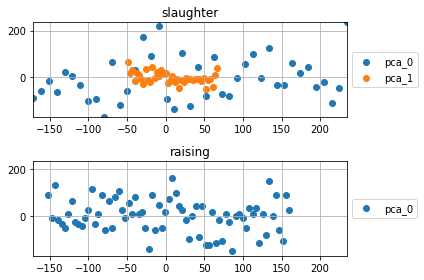

In [16]:
def training_data_visualization():
    d, testdata = SheepData().data_compression()
    pattern = re.compile(r"^pca_[0-9]{1,}$")
    fig, (ax1, ax2) = plt.subplots(2, 1)
    i = 0
    _min = []
    _max = []
    for key in d.keys():
        for _key, value in d[key].items():
            if "training data" in _key:
                data = value.loc[
                    :,list(filter(pattern.match, value.columns))
                ]
                if i == 0:
                    for column in data.columns:
                        ax1.scatter(
                            np.linspace(min(data[column]), 
                                        max(data[column]), 
                                        len(data[column])
                            ),
                            data[column],
                            label=column
                        )
                        _min.append(np.min(data[column].values))
                        _max.append(np.max(data[column].values))
                    ax1.set_ylim(min(_min), max(_max))
                    ax1.set_xlim(min(_min), max(_max))
                    ax1.grid()
                    ax1.legend(loc='center left', bbox_to_anchor=(1,0.5))
                    ax1.set_title(key)
                else:
                    for column in data.columns:
                        ax2.scatter(
                            np.linspace(min(data[column]), 
                                        max(data[column]), 
                                        len(data[column])
                            ),
                            data[column],
                            label=column
                        )
                        _min.append(np.min(data[column].values))
                        _max.append(np.max(data[column].values))
                    ax2.set_ylim(min(_min), max(_max))
                    ax2.set_xlim(min(_min), max(_max))
                    ax2.grid()
                    ax2.legend(loc='center left', bbox_to_anchor=(1,0.5))
                    ax2.set_title(key)
        i += 1
    fig.tight_layout()
training_data_visualization()

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


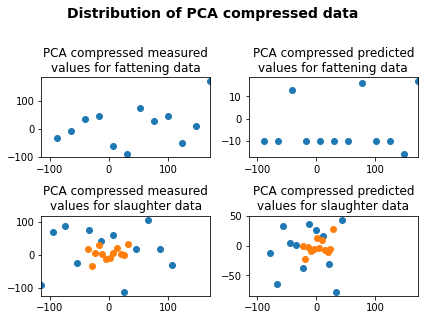

In [2]:
def plot_test_vs_prediction():
    d = SheepData().model(selected_model="lasso")
    _pred = d["Prediction"]
    _meas = d["Compressed"]
    pattern = re.compile(r"^pca_[0-9]{1,}$")
    _pred = _pred[list(filter(pattern.match, _pred.columns))]
    _meas = _meas[list(filter(pattern.match, _meas.columns))]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    _min = []
    _max = []
    i = 1
    for _dset in np.unique(_pred.index.get_level_values(0)):
        __pred = _pred.loc[pd.IndexSlice[_dset,:],:].dropna(how="all", axis=1)
        __meas = _meas.loc[pd.IndexSlice[_dset,:],:].dropna(how="all", axis=1)
        if isinstance(__pred, pd.DataFrame):
            for _c in __pred.columns:
                if i == 1:
                    ax1.scatter(
                        np.linspace(min(__meas.loc[:,_c].values), max(__meas.loc[:,_c].values), len(__meas.loc[:,_c].dropna().index)), 
                        __meas.loc[:,_c].values, 
                        label=_c
                    )
                    ax1.set_title(f"PCA compressed measured\nvalues for {_dset} data")
                    _min.append(np.min(__meas.loc[:,_c].values))
                    _max.append(np.max(__meas.loc[:,_c].values))
                    ax2.scatter(
                        np.linspace(min(__meas.loc[:,_c].values), max(__meas.loc[:,_c].values), len(__meas.loc[:,_c].dropna().index)), 
                        __pred.loc[:,_c].values,
                        label=_c
                    )
                    ax2.set_title(f"PCA compressed predicted\nvalues for {_dset} data")
                    _min.append(np.min(__pred.loc[:,_c].values))
                    _max.append(np.max(__pred.loc[:,_c].values))
                else:
                    ax3.scatter(
                        np.linspace(min(__meas.loc[:,_c].values), max(__meas.loc[:,_c].values), len(__meas.loc[:,_c].dropna().index)), 
                        __meas.loc[:,_c].values, 
                        label=_c
                    )
                    ax3.set_title(f"PCA compressed measured\nvalues for {_dset} data")
                    _min.append(np.min(__meas.loc[:,_c].values))
                    _max.append(np.max(__meas.loc[:,_c].values))
                    ax4.scatter(
                        np.linspace(min(__pred.loc[:,_c].values), max(__pred.loc[:,_c].values), len(__pred.loc[:,_c].dropna().index)), 
                        __pred.loc[:,_c].values,
                        label=_c
                    )
                    ax4.set_title(f"PCA compressed predicted\nvalues for {_dset} data")
                    _min.append(np.min(__pred.loc[:,_c].values))
                    _max.append(np.max(__pred.loc[:,_c].values))
        else:
            if i == 1:
                ax1.scatter(
                    np.linspace(min(__meas.values), max(__meas.values), len(__meas.dropna().index)), 
                    __meas.loc[:,c].values, 
                    label=_c
                )
                ax1.set_title(f"PCA compressed measured values for {_dset} data")
                _min.append(np.min(__meas.values))
                _max.append(np.max(__meas.values))
                ax2.scatter(
                    np.linspace(min(__pred.values), max(__pred.values), len(__pred.dropna().index)), 
                    __pred.loc[:,c].values,
                    label=_c
                )
                ax2.set_title(f"PCA compressed predicted values for {_dset} data")
                _min.append(np.min(__pred.values))
                _max.append(np.max(__pred.values))
            else:
                ax3.scatter(
                    np.linspace(min(__meas.values), max(__meas.values), len(__meas.dropna().index)), 
                    __meas.values, 
                    label=__meas.name
                )
                ax3.set_title(f"PCA compressed measured values for {_dset} data")
                _min.append(np.min(__meas.values))
                _max.append(np.max(__meas.values))
                ax4.scatter(
                    np.linspace(min(__meas.values), max(__meas.values), len(__meas.dropna().index)), 
                    __pred.values,
                    label=__meas.name
                )
                ax4.set_title(f"PCA compressed predicted values for {_dset} data")
                _min.append(np.min(__pred.values))
                _max.append(np.max(__pred.values))
        i += 1
    ax1.set_xlim(min(_min), max(_max))
    ax2.set_xlim(min(_min), max(_max))
    ax3.set_xlim(min(_min), max(_max))
    ax4.set_xlim(min(_min), max(_max))
    fig.tight_layout()
    fig.suptitle("Distribution of PCA compressed data", fontweight="bold", fontsize=14, y=1.1)
    #plt.savefig("../Paper/Inferring of data sets for phenotypic data/Comparison-PCA-Data.pgf", bbox_inches='tight')
    plt.show()

plot_test_vs_prediction()

In [3]:
d = SheepData().reverse_to_original()
test = SheepData().split_train_test()[1]
slaughter_vars = [
    "Sgwarm_kg",
    "Sgkalt_kg",
    "Nettozun",
    "Sklaenge_cm",
    "Schulterb_cm",
    "Keulenu_cm",
    "Keulenb_cm",
    "Nierenf_g",
    "Ofettd_cm"
]
raising_vars = [
    "Muskeld1_mm", 
    "Muskeld2_mm",
    "Fettd1_mm",
    "Fett2_mm",
    "Fleischigk1",
    "Fleischigk2",
    "Bem", 
    "LG1_kg", 
    "LG3_kg", 
    "TZ2_g"
]
r = pd.DataFrame()
for dataset in np.unique(d["Reversed"].index.get_level_values(0)):
    data = d["Reversed"].loc[pd.IndexSlice[dataset,:],:]
    if "slaughter" in dataset:
        destvars = slaughter_vars
    else:
        destvars = raising_vars
    _r = pd.Series(name=dataset, index=destvars, dtype=np.float64)
    for var in destvars:
        predicted = data.loc[:,var]
        measured = test.loc[:,var]
        _pred = predicted.reset_index(drop=True).astype(np.float64)
        _meas = measured.reset_index(drop=True).astype(np.float64)
        _r.loc[var] = _pred.corr(_meas.iloc[:len(_pred)])
    r = pd.concat([r, _r], axis=1)
r

raising  slaughter
Muskeld1_mm  -0.044314        NaN
Muskeld2_mm   0.109632        NaN
Fettd1_mm    -0.154037        NaN
Fett2_mm      0.182311        NaN
Fleischigk1  -0.147959        NaN
Fleischigk2  -0.040799        NaN
Bem          -0.175402        NaN
LG1_kg       -0.226383        NaN
LG3_kg       -0.140526        NaN
TZ2_g        -0.190945        NaN
Sgwarm_kg          NaN   0.024840
Sgkalt_kg          NaN   0.013211
Nettozun           NaN  -0.200455
Sklaenge_cm        NaN  -0.444427
Schulterb_cm       NaN  -0.245089
Keulenu_cm         NaN   0.019488
Keulenb_cm         NaN  -0.145474
Nierenf_g          NaN   0.011233
Ofettd_cm          NaN   0.040248

In [14]:
test_ratios = 1 - np.arange(50, 100, 5)/100
df = pd.DataFrame()
sort_by_breed = [True, False]
for option in sort_by_breed:
    if option is True:
        _name = "sorted"
    if option is False:
        _name = "unsorted"
    rmeans = pd.DataFrame()
    p_values = pd.DataFrame()
    for val in test_ratios:
        try:
            rmean, pvalue = SheepData().determine_deviation(
                test_ratio=val, sort_by_breed=option, alpha=None
            )
        except ValueError:
            continue
        rmean.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Root squared mean", len(rmean.columns))),
                list(itertools.repeat(_name, len(rmean.columns))), 
                list(itertools.repeat(val, len(rmean.columns))), 
                rmean.columns
            ], names=["Measure", "Sort", "TestRatio", "Columns"]
        )
        pvalue.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("p-values", len(pvalue.columns))),
                list(itertools.repeat(_name, len(pvalue.columns))), 
                list(itertools.repeat(val, len(pvalue.columns))), 
                pvalue.columns
            ], names=["Measure", "Sort", "TestRatio", "Columns"]
        )
        rmeans = pd.concat([rmeans, rmean], axis=1)
        p_values = pd.concat([p_values, pvalue], axis=1)
    df = pd.concat([df, rmeans], axis=1)
    df = pd.concat([df, p_values], axis=1)
df#.to_csv(f"{SheepData().sheep_folder}/Results.csv")

Measure      Root squared mean                                              \
Sort                    sorted                                               
TestRatio                 0.50                  0.45                  0.40   
Columns                raising  slaughter    raising  slaughter    raising   
Muskeld1_mm           5.038545        NaN   5.240739        NaN   4.718816   
Muskeld2_mm           3.578212        NaN   3.704155        NaN   3.505013   
Fettd1_mm             1.596801        NaN   1.628930        NaN   1.481206   
Fett2_mm              1.504616        NaN   1.523251        NaN   1.591142   
Fleischigk1           1.096392        NaN   1.203562        NaN   1.208583   
Fleischigk2                NaN        NaN        NaN        NaN        NaN   
Bem                        NaN        NaN        NaN        NaN        NaN   
LG1_kg                9.539082        NaN  10.282877        NaN   9.887118   
LG3_kg               11.083006        NaN  11.469395        NaN  11.543131   
TZ2_g                95.380175        NaN  96.914544        NaN  83.879673   
Sgwarm_kg                  NaN   5.310541        NaN   5.119118        NaN   
Sgkalt_kg                  NaN   5.250854        NaN   5.067912        NaN   
Nettozun                   NaN  35.356098        NaN  34.239736        NaN   
Sklaenge_cm                NaN   3.190165        NaN   2.850942        NaN   
Schulterb_cm               NaN   2.560986        NaN   2.730424        NaN   
Keulenu_cm                 NaN   6.052065        NaN   6.009143        NaN   
Keulenb_cm                 NaN   2.304736        NaN   2.289010        NaN   
Nierenf_g                  NaN  85.323549        NaN  84.926813        NaN   
Ofettd_cm                  NaN   0.175809        NaN   0.148826        NaN   

Measure                                        p-values            ...  \
Sort                                             sorted            ...   
TestRatio                     0.35                 0.50            ...   
Columns       slaughter    raising  slaughter   raising slaughter  ...   
Muskeld1_mm         NaN   4.940537        NaN  0.979773       NaN  ...   
Muskeld2_mm         NaN   3.585890        NaN  0.983122       NaN  ...   
Fettd1_mm           NaN   1.486053        NaN  0.995135       NaN  ...   
Fett2_mm            NaN   1.666857        NaN  0.988323       NaN  ...   
Fleischigk1         NaN   1.264221        NaN  0.988434       NaN  ...   
Fleischigk2         NaN        NaN        NaN       NaN       NaN  ...   
Bem                 NaN        NaN        NaN       NaN       NaN  ...   
LG1_kg              NaN   9.520130        NaN  0.995398       NaN  ...   
LG3_kg              NaN  11.121718        NaN  0.997098       NaN  ...   
TZ2_g               NaN  87.687947        NaN  0.999998       NaN  ...   
Sgwarm_kg      6.021066        NaN   6.239778       NaN  0.776476  ...   
Sgkalt_kg      5.961529        NaN   6.241811       NaN  0.786449  ...   
Nettozun      40.061784        NaN  37.765181       NaN  0.782434  ...   
Sklaenge_cm    3.746446        NaN   2.951653       NaN  0.926018  ...   
Schulterb_cm   2.872351        NaN   3.142761       NaN  0.944532  ...   
Keulenu_cm     7.005689        NaN   7.536009       NaN  0.743124  ...   
Keulenb_cm     2.558190        NaN   2.703156       NaN  0.896606  ...   
Nierenf_g     92.642741        NaN  96.884559       NaN  0.988602  ...   
Ofettd_cm      0.172676        NaN   0.165852       NaN  0.907325  ...   

Measure                                                                   \
Sort          unsorted                                                     
TestRatio         0.35                0.30                0.25             
Columns        raising slaughter   raising slaughter   raising slaughter   
Muskeld1_mm   0.986191       NaN  0.872936       NaN  0.740760       NaN   
Muskeld2_mm   0.993067       NaN  0.989996       NaN  0.890123       NaN   
Fettd1_mm     0.994906       NaN  0.822689    

In [13]:
import ast
d = pd.read_csv(f"{SheepData().sheep_folder}/2020-06-15 Hyperparameter_Schafe.csv", header=[0,1,2], index_col=0)
#d.columns = pd.MultiIndex.from_tuples(d.columns, names=["Alpha", "Compressed", "Measures"])
_cols = []
for _col in d.columns:
    if isinstance(_col, str):
        _cols.append(ast.literal_eval(re.findall(r'(\(.*?\)).',_col)[0]))
        # This solution has been posted to stackoverflow. Only the variable names have been adapted
        # https://stackoverflow.com/questions/53022580/handling-error-typeerror-expected-tuple-got-str-loading-a-csv-to-pandas-mult/53024524#53024524
    else:
        _cols.append(_col)
d.columns = pd.MultiIndex.from_tuples(_cols, names=["Alpha", "Compressed", "Measures"])
d

Alpha              0.9999                                         0.9998  \
Compressed   Uncompressed             Compressed            Uncompressed   
Measures          raising   slaughter    raising  slaughter      raising   
Muskeld1_mm      4.327418         NaN        NaN        NaN     4.327415   
Muskeld2_mm      3.456440         NaN        NaN        NaN     3.456441   
Fettd1_mm        1.167519         NaN        NaN        NaN     1.167518   
Fett2_mm         1.608772         NaN        NaN        NaN     1.608772   
Fleischigk1      1.156375         NaN        NaN        NaN     1.156374   
Fleischigk2      0.559429         NaN        NaN        NaN     0.559427   
Bem              1.026919         NaN        NaN        NaN     1.026919   
LG1_kg           8.311973         NaN        NaN        NaN     8.311965   
LG3_kg           7.753859         NaN        NaN        NaN     7.753863   
TZ2_g           74.148973         NaN        NaN        NaN    74.148425   
Sgwarm_kg             NaN    3.633147        NaN        NaN          NaN   
Sgkalt_kg             NaN    3.584785        NaN        NaN          NaN   
Nettozun              NaN   13.541859        NaN        NaN          NaN   
Sklaenge_cm           NaN    2.018797        NaN        NaN          NaN   
Schulterb_cm          NaN    1.778470        NaN        NaN          NaN   
Keulenu_cm            NaN    3.718450        NaN        NaN          NaN   
Keulenb_cm            NaN    1.199877        NaN        NaN          NaN   
Nierenf_g             NaN  113.961746        NaN        NaN          NaN   
Ofettd_cm             NaN    0.181422        NaN        NaN          NaN   
pca_0                 NaN         NaN  89.471237  49.849169          NaN   
pca_1                 NaN         NaN        NaN  31.019328          NaN   

Alpha                                               0.9997              ...  \
Compressed               Compressed           Uncompressed              ...   
Measures       slaughter  slaughter slaughter      raising   slaughter  ...   
Muskeld1_mm          NaN        NaN       NaN     4.327411         NaN  ...   
Muskeld2_mm          NaN        NaN       NaN     3.456442         NaN  ...   
Fettd1_mm            NaN        NaN       NaN     1.167517         NaN  ...   
Fett2_mm             NaN        NaN       NaN     1.608772         NaN  ...   
Fleischigk1          NaN        NaN       NaN     1.156374         NaN  ...   
Fleischigk2          NaN        NaN       NaN     0.559424         NaN  ...   
Bem                  NaN        NaN       NaN     1.026919         NaN  ...   
LG1_kg               NaN        NaN       NaN     8.311956         NaN  ...   
LG3_kg               NaN        NaN       NaN     7.753866         NaN  ...   
TZ2_g                NaN        NaN       NaN    74.147876         NaN  ...   
Sgwarm_kg       3.633160        NaN       NaN          NaN    3.633173  ...   
Sgkalt_kg       3.584796        NaN       NaN          NaN    3.584807  ...   
Nettozun       13.541379        NaN       NaN          NaN   13.540899  ...   
Sklaenge_cm     2.018825        NaN       NaN          NaN    2.018853  ...   
Schulterb_cm    1.778451        NaN       NaN          NaN    1.778432  ...   
Keulenu_cm      3.718452        NaN       NaN          NaN    3.718455  ...   
Keulenb_cm      1.199865        NaN       NaN          NaN    1.199853  ...   
Nierenf_g     113.962814        NaN       NaN          NaN  113.963883  ...   
Ofettd_cm       0.181423        NaN       NaN          NaN    0.181424  ...   
pca_0                NaN   49.84948  49.84948          NaN         NaN  ...   
pca_1                NaN   31.02043  31.02043          NaN         NaN  ...   

Alpha            0.0003                  0.0002                         \
Compressed   Compressed            Uncompressed             Compressed   
Measures      slaughter  slaughter      raising   slaughter  slaughter   
Muskeld1_mm         NaN        NaN     4.331959         

In [8]:
_d = d.dropna(how="all", axis=1)
res = pd.DataFrame()
for measure in np.unique(d.columns.get_level_values("Measures")):
    for compression in np.unique(d.columns.get_level_values("Compressed")):
        _selected = _d.loc[:,pd.IndexSlice[:,compression,measure]].dropna(how="all", axis=0)
        _r = pd.DataFrame(columns=["Alpha", "Deviation"], index=_selected.index)
        for l in _selected.index:
            _dat = _selected.loc[l,:]
            _min = _dat.min()
            _r.loc[l, "Deviation"] = _min
            if len(_dat.loc[_dat == _min].index) == 1:
                _r.loc[l, "Alpha"] = _dat.loc[_dat == _min].index.get_level_values(0)[0]
            if len(_dat.loc[_dat == _min].index) < 1:
                continue
            if len(_dat.loc[_dat == _min].index) > 1:
                _al_val = _dat.loc[_dat == _min].index.get_level_values(0).tolist()
                al_val = [np.float(_x) for _x in _al_val]
                _r.loc[l, "Alpha"] = np.median(al_val)
                #pca = decomposition.PCA(svd_solver="full")
                #_fit = pca.fit_transform(_al_val.reshape(-1, 1))
                #print(_fit)
        _r.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat(measure, len(_r.columns))), 
                _r.columns
            ], names=["Measure", "Values"]
        )
        res = pd.concat([res, _r], axis=1)
res.to_csv(f"{SheepData().sheep_folder}/Alpha_values_for_minimized_deviation.csv")

In [32]:
d = SheepData().model(selected_model="elastic")["Prediction"]
pattern = re.compile(r"pca\_[0-9]{1,}")
_d = d.loc[:,list(filter(pattern.match, d.columns))]
_d

pca_0      pca_1
Dataset   Original                      
slaughter 18        -1.617282  -3.413572
          49        -1.617282  -3.413572
          30        -1.617281  -3.413572
          22        -1.617281  -3.413572
          39        -1.617281  -3.413572
          82        -1.617281  -3.413572
          0         -1.617281  12.691520
          42        -1.617281  -3.413572
          4         -1.617281  -3.413572
          78        -1.617281  -3.413572
raising   12        39.665149        NaN
          18       -10.643325        NaN
          49       -10.643324        NaN
          30       -10.643323        NaN
          53       -10.643323        NaN
          22       -10.643323        NaN
          44       -10.643323        NaN
          39       -10.643323        NaN
          33       -10.643323        NaN
          82       -10.643323        NaN
          81       -10.643323        NaN
          0         39.664261        NaN
          42       -10.643323        NaN
          64       -10.643323        NaN
          4        -10.643324        NaN
          10       -10.643324        NaN
          78       -10.643323        NaN

In [36]:
x_vars = pd.read_csv(
    os.path.join(SheepData().sheep_folder, "model/slaughter/X-Variable.csv"), 
    index_col=0, 
    header=0
)
d, o = SheepData(read_alphas=True).data_cleaning()
r = pd.DataFrame(index=x_vars.index, columns=["Orig", "Dropna", "Name", "Percentage"])
for c in x_vars.index:
    _data = d.loc[:,x_vars.loc[c]]
    r.loc[c, "Orig"] = len(_data.index)
    r.loc[c, "Dropna"] = len(_data.dropna().index)
    r.loc[c, "Name"] = x_vars.loc[c].values[0]
    r.loc[c, "Percentage"] = r.loc[c, "Dropna"]/r.loc[c, "Orig"]
r.loc[r["Percentage"] < 1]

Orig Dropna         Name Percentage
19   89     51  Fleischigk2   0.573034
20   89     83          Bem   0.932584
21   89     83        Ersch   0.932584
22   89     32    Zuchtwert   0.359551

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.177e+00, with an

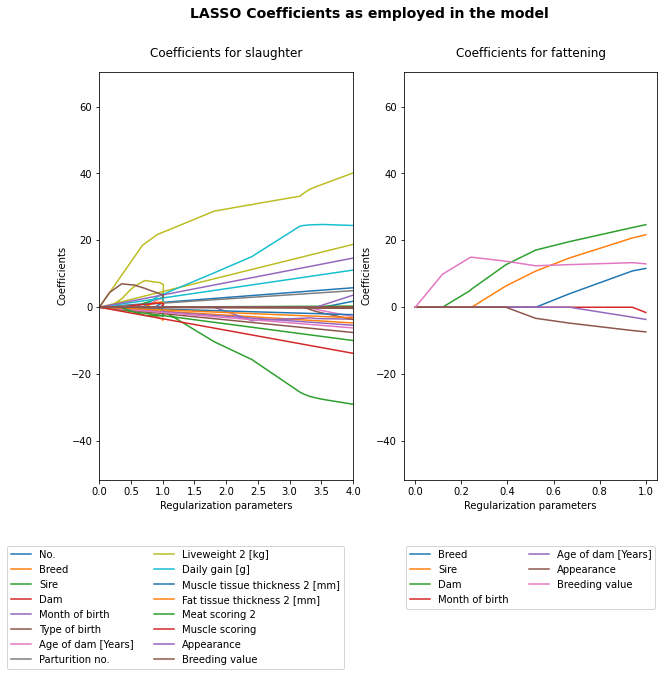

In [10]:
def coeff_plotting():
    coeffs = SheepData().model(selected_model="lasso")["Coefficients"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7.5))
    _min = []
    _max = []
    for usecase in np.unique(coeffs.index.get_level_values("Usecase")):
        data = coeffs.loc[pd.IndexSlice[usecase, :],:].dropna(how="all", axis=1)
        data = data.replace(0, np.NaN).dropna(how="all", axis=1)
        drop_cols = [
                "Alter1_Tage", 
                "Alter2_Tage", 
                "LG1_kg", 
                "Muskeld1_mm", 
                "Fettd1_mm", 
                "Fleischigk1"
            ]
        for x in drop_cols:
            if x in data.columns:
                data.drop(x, axis=1, inplace=True)
            else:
                continue
        cols = {
            "Nummer":"No.", 
            "Rasse":"Breed",
            "Vater":"Sire", 
            "Mutter":"Dam", 
            "Gebmonat":"Month of birth", 
            "Gebtyp":"Type of birth", 
            "Alter_Mutter_J":"Age of dam [Years]", 
            "AblammNr":"Parturition no.",
            "Alter1_Tage":"Age 1 [d]",
            "Alter2_Tage":"Age 2 [d]",
            "Alter3_Tage":"Age 3 [d]",
            "LG1_kg":"Liveweight 1 [kg]", 
            "LG3_kg":"Liveweight 2 [kg]", 
            "TZ2_g":"Daily gain [g]", 
            "Muskeld1_mm":"Muscle tissue thickness 1 [mm]", 
            "Muskeld2_mm":"Muscle tissue thickness 2 [mm]", 
            "Fettd1_mm":"Fat tissue thickness 1 [mm]", 
            "Fett2_mm":"Fat tissue thickness 2 [mm]",
            "Fleischigk1":"Meat scoring 1", 
            "Fleischigk2":"Meat scoring 2", 
            "Bem":"Muscle scoring", 
            "Ersch":"Appearance", 
            "Zuchtwert":"Breeding value",
            "Sgwarm_kg":"Hot carcass weight [kg]", 
            "Sgkalt_kg":"Cold carcass weight [kg]",
            "Nettozun":"Net weight gain [g]",
            "Sklaenge_cm":"Carcass length [cm]",
            "Schulterb_cm":"Shoulder width [cm]", 
            "Keulenu_cm":"Shank diameter [cm]", 
            "Keulenb_cm":"Shank width [cm]",
            "Nierenf_g":"Kidney fat [g]",
            "Ofettd_cm":"Fat cover [cm]"
        }
        data.rename(cols, axis=1, inplace=True)
        data = data.fillna(0).T
        xx = data.abs().sum(axis=0)
        xx /= xx.iloc[-1]
        for i in data.index:
            if "slaughter" in usecase:
                ax1.plot(xx, data.loc[i, :], label=i)
                ax1.set_title(f"Coefficients for {usecase}", pad=15)
            else:
                ax2.plot(xx, data.loc[i, :], label=i)
                ax2.set_title(f"Coefficients for {usecase}", pad=15)
        if "slaughter" in usecase:
            ax1.legend(loc='upper center', bbox_to_anchor=(0.3, -0.15), ncol=2)
            ax1.set_xlabel("Regularization parameters")
            ax1.set_ylabel("Coefficients")
        else:
            ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
            ax2.set_xlabel("Regularization parameters")
            ax2.set_ylabel("Coefficients")
        _min.append(np.min(data.values))
        _max.append(np.max(data.values))
    ax1.set_ylim(min(_min), max(_max))
    ax1.set_xlim(0, 4)
    #ax2.set_xlim(0, 2)
    #ax1.set_xscale("log")
    ax2.set_ylim(min(_min), max(_max))
    plt.suptitle("LASSO Coefficients as employed in the model", fontweight="bold", y=1, fontsize=14)
    # for interpretation please refer to:
    # https://stats.stackexchange.com/questions/68431/interpretting-lasso-variable-trace-plots/68435#68435
    plt.subplots_adjust(hspace=0.75)
    plt.savefig(f"../Paper/Inferring of data sets for phenotypic data/Coefficients.png", bbox_inches='tight')
    plt.show()

coeff_plotting()

In [23]:
d = SheepData().determine_deviation(selected_model="lasso", sort_by_breed=False, persistent=True)
p = pd.DataFrame()
for col in d["Uncompressed p-value"].columns:
    vals = d["Uncompressed p-value"].loc[:,col].dropna(how="all") > 0.05
    p = pd.concat([p, vals], axis=1)
rsme = d["Uncompressed Deviation"].round(3)
rsme.columns = [f"RSME {x}" for x in rsme.columns]
p.columns = [f"Significance {_x}" for _x in p.columns]
index = {
        "Nummer":"No.", 
        "Rasse":"Breed",
        "Vater":"Sire", 
        "Mutter":"Dam", 
        "Gebmonat":"Month of Birth", 
        "Gebtyp":"Type of Birth", 
        "Alter_Mutter_J":"Age of Dam [Years]", 
        "AblammNr":"Parturition No.",
        "Alter1_Tage":"Age 1 [d]",
        "Alter2_Tage":"Age 2 [d]",
        "Alter3_Tage":"Age 3 [d]",
        "LG1_kg":"Liveweight 1 [kg]", 
        "LG3_kg":"Liveweight 3 [kg]", 
        "TZ2_g":"Daily Gain [g]", 
        "Muskeld1_mm":"Muscle Tissue Thickness 1 [mm]", 
        "Muskeld2_mm":"Muscle Tissue Thickness 2 [mm]", 
        "Fettd1_mm":"Fat Tissue Thickness 1 [mm]", 
        "Fett2_mm":"Fat Tissue Thickness 2 [mm]",
        "Fleischigk1":"Meat Scoring 1", 
        "Fleischigk2":"Meat Scoring 2", 
        "Bem":"Muscle Scoring", 
        "Ersch":"Appearance", 
        "Zuchtwert":"Breeding value",
        "Sgwarm_kg":"Warm carcass weight [kg]", 
        "Sgkalt_kg":"Cold carcass weight [kg]",
        "Nettozun":"Net weight gain [g]",
        "Sklaenge_cm":"Carcass length [cm]",
        "Schulterb_cm":"Shoulder width [cm]", 
        "Keulenu_cm":"Shank diameter [cm]", 
        "Keulenb_cm":"Shank width [cm]",
        "Nierenf_g":"Kidney fat [g]",
        "Ofettd_cm":"Fat cover [cm]"
    }
'''
with open("../Paper/Inferring of data sets for phenotypic data/Training-p-results.tex", "w+") as texfile:
    p.rename(index, axis=0, inplace=True)
    _p = p.to_latex(
        na_rep='0', 
        column_format="|p{0.2\linewidth}|p{0.2\linewidth}|p{0.2\linewidth}|"
    )
    texfile.write(_p)
with open("../Paper/Inferring of data sets for phenotypic data/Training-rsme-results.tex", "w+") as _texfile:
    rsme.rename(index, axis=0, inplace=True)
    _rsme = rsme.to_latex(
        na_rep="0", column_format="|p{0.2\linewidth}|p{0.2\linewidth}|p{0.2\linewidth}|"
    )
    _texfile.write(_rsme)
'''
p

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

Significance raising Significance slaughter
Muskeld1_mm                  True                    NaN
Muskeld2_mm                  True                    NaN
Fettd1_mm                    True                    NaN
Fett2_mm                     True                    NaN
Fleischigk1                  True                    NaN
Fleischigk2                  True                    NaN
Bem                          True                    NaN
LG1_kg                       True                    NaN
LG3_kg                       True                    NaN
TZ2_g                        True                    NaN
Sgwarm_kg                     NaN                   True
Sgkalt_kg                     NaN                   True
Nettozun                      NaN                   True
Sklaenge_cm                   NaN                   True
Schulterb_cm                  NaN                   True
Keulenu_cm                    NaN                   True
Keulenb_cm                    NaN                   True
Nierenf_g                     NaN                   True
Ofettd_cm                     NaN                   True

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

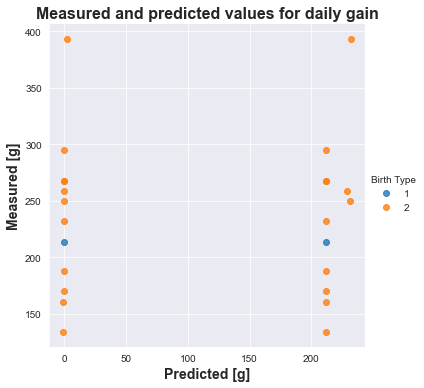

In [39]:
import seaborn as sns
def plot_tz():
    d = SheepData().reverse_to_original(selected_model="lasso", sort_by_breed=False, persistent=False)
    _reversed = d["Reversed"]
    _original = d["Test"]
    data = pd.concat([_reversed["TZ2_g"], _original["TZ2_g"], _original["Gebtyp"]], axis=1).dropna(how="all").astype(np.int)
    data.columns = ["Predicted [g]", "Measured [g]", "Birth Type"]
    sns.lmplot(y="Measured [g]", x="Predicted [g]", data=data, fit_reg=False, hue="Birth Type")
    sns.set_style("darkgrid")
    ax = plt.gca()
    ax.set_title("Measured and predicted values for daily gain", fontweight="bold", fontsize=16)
    ax.set_ylabel("Measured [g]", fontweight="bold", fontsize=14)
    ax.set_xlabel("Predicted [g]", fontweight="bold", fontsize=14)
    
plot_tz()

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

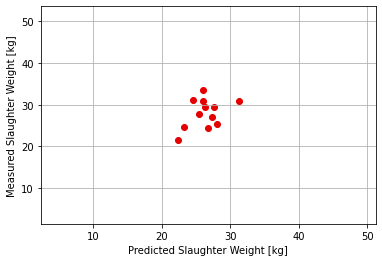

In [11]:
def plot_sg():
    d = SheepData().reverse_to_original(selected_model="lasso", sort_by_breed=False, persistent=False)
    _reversed = d["Reversed"]
    _original = d["Test"]
    plt.scatter(_reversed.loc[:,"Sgwarm_kg"], _original.loc[:,"Sgwarm_kg"], color="xkcd:red")
    plt.ylim(_original.loc[:,"Sgwarm_kg"].min() - 20, _original.loc[:,"Sgwarm_kg"].max() + 20)
    plt.xlim(_reversed.loc[:,"Sgwarm_kg"].min() - 20, _reversed.loc[:,"Sgwarm_kg"].max() + 20)
    plt.xlabel("Predicted Slaughter Weight [kg]")
    plt.ylabel("Measured Slaughter Weight [kg]")
    plt.grid()
    #plt.title("Comparison of predicted and measured\nslaughter weight")
    plt.savefig("../Paper/Inferring of data sets for phenotypic data/Scatter-Plot-SG.png")
    
plot_sg()

In [35]:
ud = d["Uncompressed Deviation"].rename(index, axis=0)
ud.columns = pd.MultiIndex.from_arrays(
    [np.repeat("RSME", len(ud.columns)), ud.columns], names=["Statistics", "Measure"]
)
up = d["Uncompressed p-value"].rename(index, axis=0)
up = up > 0.05
up["raising"] = up["raising"].apply(lambda x: "True" if x is True else "False")
up["slaughter"] = up["slaughter"].apply(lambda x: "True" if x is True else "False")
up.columns = pd.MultiIndex.from_arrays(
    [np.repeat("p values", len(ud.columns)), up.columns], names=["Statistics", "Measure"]
)
res = pd.concat([ud, up], axis=1)
res = res.round(3)
res.to_excel("../Daten/Schafe/Training-Results.xlsx", float_format="%.3f")
res

Statistics                        RSME           p values          
Measure                        raising slaughter  raising slaughter
Muscle Tissue Thickness 1 [mm]   2.803       NaN     True     False
Muscle Tissue Thickness 2 [mm]   1.758       NaN     True     False
Fat Tissue Thickness 1 [mm]      1.257       NaN     True     False
Fat Tissue Thickness 2 [mm]      0.714       NaN     True     False
Meat Scoring 1                   1.075       NaN     True     False
Meat Scoring 2                   0.653       NaN     True     False
Muscle Scoring                   0.667       NaN     True     False
Liveweight 1 [kg]                6.444       NaN     True     False
Liveweight 3 [kg]                7.072       NaN     True     False
Daily Gain [g]                  69.639       NaN     True     False
Warm carcass weight [kg]           NaN     3.737    False      True
Cold carcass weight [kg]           NaN     3.752    False      True
Net weight gain [g]                NaN    16.673    False      True
Carcass length [cm]                NaN     2.344    False      True
Shoulder width [cm]                NaN     1.789    False      True
Shank diameter [cm]                NaN     4.483    False      True
Shank width [cm]                   NaN     1.593    False      True
Kidney fat [cm]                    NaN    89.338    False      True
Fat cover [cm]                     NaN     0.216    False      True